In [1]:
# core
import pandas as pd
import numpy as np
import joblib

# Data Preparation utils
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)
from utils.preprocess_pipeline import PreprocessTransformer
from sklearn.pipeline import Pipeline

# model evaluation
from sklearn.metrics import ConfusionMatrixDisplay

# segmentation
from utils.segmentation import assign_customer_segment


In [2]:
# load complete_df from data
df = pd.read_parquet(
    "../data/initial_dfs/complete_df.parquet",
    engine="pyarrow"
)

# split features and target as X and Y
X = df.drop(columns=["Churn Value"])
Y = df["Churn Value"]

In [3]:
# load pipeline
pipe = joblib.load("../models/best_churn_pipeline.pkl")

In [4]:
# apply model to predict churn and add them as new columns
predictions = pipe.predict(X)
predictions_proba = pipe.predict_proba(X)[:, 1]

treshold = 0.6
predictions_treshold  = (predictions_proba >= treshold).astype(int)

# include predictions in the original dataframe
X["Churn Prediction"] = predictions_treshold
X["Churn Prediction Probability"] = predictions_proba

c:\Users\pedro\Projects\telco_churn\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pedro\Projects\telco_churn\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __

In [5]:
print(f"shape of df: {X.shape}")
X.head(2)

shape of df: (7043, 53)


,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,...,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason,ID,Population,Churn Prediction,Churn Prediction Probability
Customer ID,,,,,,,,,,,,,,,,,,,,,
8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,Los Angeles,...,Churned,Yes,91,5433,Competitor,Competitor offered more data,21,68701,1,0.943437
7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,Los Angeles,...,Churned,Yes,69,5302,Competitor,Competitor made better offer,54,55668,1,0.847831


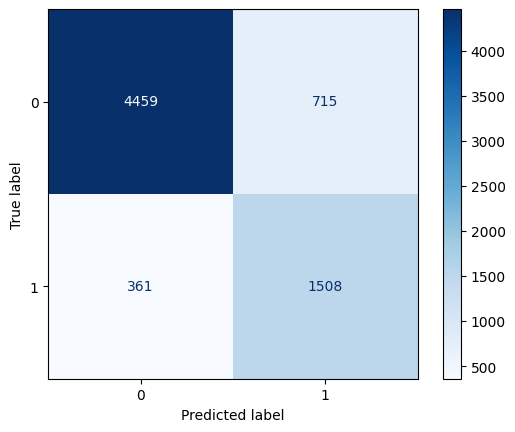

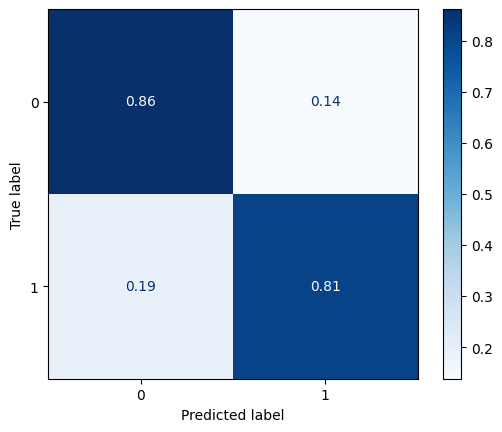

In [12]:
# plot 2 confusion matrix as subplots: one not normalized and other normalized

ConfusionMatrixDisplay.from_predictions(
    Y,
    predictions_treshold,
    cmap="Blues",
    normalize=None,
    values_format=".0f"
)

ConfusionMatrixDisplay.from_predictions(
    Y,
    predictions_treshold,
    cmap="Blues",
    normalize="true",
    values_format=".2f"
)

In [15]:
# proportion of value counts of Paperless Billing in df_final
df_final['Contract'].value_counts(normalize=True)

Contract
Month-to-Month    0.512566
Two Year          0.267358
One Year          0.220077
Name: proportion, dtype: float64

In [7]:
# join df_proc['Churn Prediction'] and df_proc['Churn Prediction Probability'] to original df on index
df_final = df.join(
    X[["Churn Prediction", "Churn Prediction Probability"]],
    how="left"
)

In [8]:
# assign customer segments to df_final using assign_customer_segment function
df_final = assign_customer_segment(df_final)

print(f"shape of final df: {df_final.shape}")

# show max cols
pd.set_option('display.max_columns', None)
df_final.head(5)

shape of final df: (7043, 55)


,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Quarter,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason,ID,Population,Churn Prediction,Churn Prediction Probability,segment
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.023810,-118.156582,No,0,1,None,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,Q3,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data,21,68701,1,0.943437,New Customer
7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10,Q3,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer,54,55668,1,0.847831,+65y
1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,Los Angeles,90065,"34.108833, -118.229715",34.108833,-118.229715,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,52,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Q3,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer,56,47534,1,0.911336,+65y
4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,Inglewood,90303,"33.936291, -118.332639",33.936291,-118.332639,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,12,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Q3,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services,100,27778,1,0.728885,+65y
4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,Whittier,90602,"33.972119, -118.020188",33.972119,-118.020188,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,14,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Q3,2,Churned,Yes,1,67,2793,Price,Extra data charges,114,26265,1,0.903923,+65y


In [28]:
df_final['Payment Method'].value_counts(normalize=True)

Payment Method
Bank Withdrawal    0.555019
Credit Card        0.390317
Mailed Check       0.054664
Name: proportion, dtype: float64

In [29]:
# calculate 'Churn Value' combinations grouped by 'Internet Type'
churn_by_internet_type = df_final.groupby('Payment Method')['Churn Value'].value_counts(normalize=True).unstack().fillna(0)
churn_by_internet_type

Churn Value,0,1
Payment Method,,
Bank Withdrawal,0.660015,0.339985
Credit Card,0.855220,0.144780
Mailed Check,0.631169,0.368831


In [9]:
# save df_final to data/final_dfs/df_final.parquet
df_final.to_parquet("../data/final_dfs/df_final.parquet")

In [10]:
# Create X with model features and preprocess and save it in data/final_dfs/X.parquet

print(f"df_final shape: {df_final.shape}")

X = df_final.drop(columns=["segment"])
X = PreprocessTransformer().fit_transform(X)

print(f"X shape: {X.shape}")

X.to_parquet("../data/final_dfs/X.parquet")

df_final shape: (7043, 55)
X shape: (7043, 12)


In [11]:
X.head(2)

,Contract Duration,Dependents,Internet Type,Monthly Charge,Number of Referrals_bins,Paperless Billing,Payment Method_Credit Card,Senior Citizen,Tenure in Months,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Unlimited Data
Customer ID,,,,,,,,,,,,
8779-QRDMV,0.0,0.0,0.0,-0.564857,0.0,0.0,0.0,1.0,-0.608696,20.0,-0.842008,-1.0
7495-OOKFY,0.0,1.0,0.5,0.189512,0.5,0.0,1.0,1.0,-0.456522,0.0,0.954938,0.0
